# Mid-Bootcamp Project - Classification

In [25]:
# import relevant libraries

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import getpass 
import plotly.express as px


import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency


In [2]:
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)

In [3]:
# pull data from mysql database into pandas dataframe

query = '''SELECT *
           FROM credit_card_data
           ;'''

data = pd.read_sql_query(query, engine)
data

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,No_Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,No_Credit_Cards_Held,No_Homes_Owned,Household_Size,Own_Your_Home,Average_Balance,Q1_Balance,Q2_Balance,Q3_Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865


## Stage 1 - Data cleaning & exploratory data analysis

In [4]:
# customer number can be used as the index

data = data.set_index('Customer_Number')

In [5]:
# standardise column names

data.columns= data.columns.str.strip().str.lower()
data.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'no_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'no_credit_cards_held', 'no_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance'],
      dtype='object')

In [6]:
data.shape, data.dtypes


((17976, 15),
 offer_accepted            object
 reward                    object
 mailer_type               object
 income_level              object
 no_bank_accounts_open      int64
 overdraft_protection      object
 credit_rating             object
 no_credit_cards_held       int64
 no_homes_owned             int64
 household_size             int64
 own_your_home             object
 average_balance          float64
 q1_balance                 int64
 q2_balance                 int64
 q3_balance                 int64
 dtype: object)

In [14]:
# check central tendencies and spread of data
# we can see that number of bank accounts, no of credit cards held & no of homes owned do not have much variance
# household size and the balance columns have some outliers at the higher end

summary = data.describe().T 
summary['iqr'] = summary['75%']-summary['25%'] 
summary = summary.apply(round)
summary

,count,mean,std,min,25%,50%,75%,max,iqr
no_bank_accounts_open,17976.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
no_credit_cards_held,17976.0,2.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0
no_homes_owned,17976.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
household_size,17976.0,3.0,1.0,1.0,3.0,3.0,4.0,9.0,1.0
average_balance,17976.0,941.0,350.0,48.0,788.0,1007.0,1153.0,3366.0,366.0
q1_balance,17976.0,910.0,620.0,0.0,393.0,772.0,1521.0,3450.0,1128.0
q2_balance,17976.0,999.0,457.0,0.0,663.0,1032.0,1342.0,3421.0,679.0
q3_balance,17976.0,1042.0,553.0,0.0,633.0,946.0,1463.0,3823.0,830.0


In [8]:
# check for nulls - luckily there are none here :)

data.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
no_bank_accounts_open    0
overdraft_protection     0
credit_rating            0
no_credit_cards_held     0
no_homes_owned           0
household_size           0
own_your_home            0
average_balance          0
q1_balance               0
q2_balance               0
q3_balance               0
dtype: int64

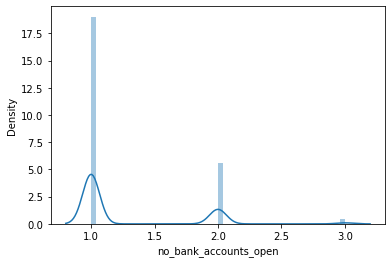

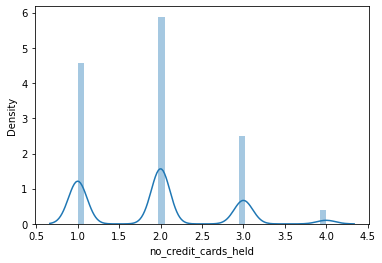

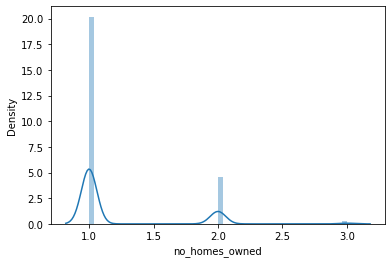

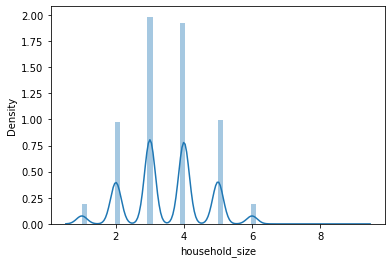

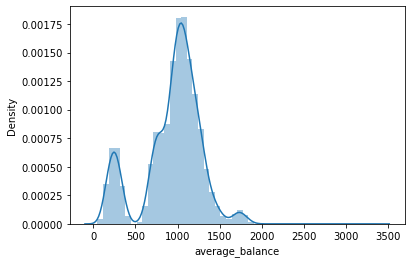

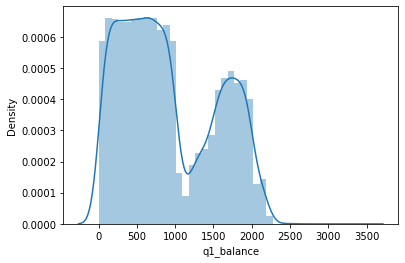

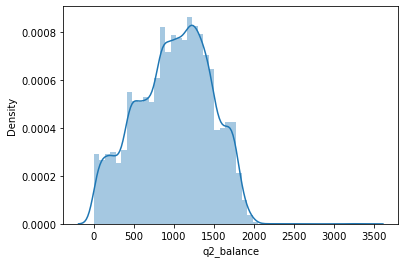

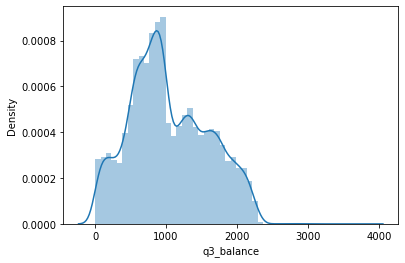

In [10]:
# check distribution of numerical columns 
# balance columns could use a log transform or box cox to make the distribution more normal

for col in data.select_dtypes(np.number):
    sns.distplot(data[col])
    plt.show()

In [11]:
# check counts of categorical variables per column
# in general the different categorical variables are evenly distributed except our target variable offer_accepted and overdraft_protection and own_yor_own_home

for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



In [43]:
for col in data.select_dtypes(include='object'):
    px.histogram(data[col],width=700, height=500).show()

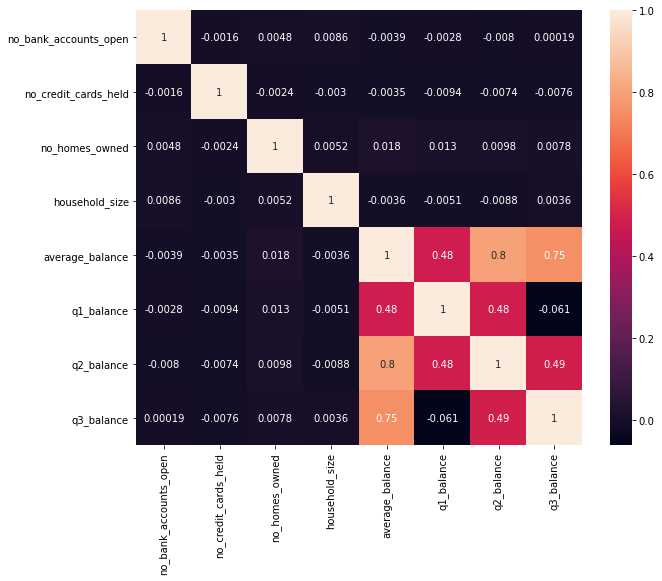

In [12]:
# check correlation of data
# based on this I would drop Q1, Q2 & Q3 balance as they have high multicollinearity and we have the average balance anyway

corr_matrix=data.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [27]:
# let's check the VIF too

data1 = data.copy()
numericals = data1.select_dtypes(np.number)

In [28]:
# add constant to numerical variables

vif_numericals = add_constant(numericals)
vif_numericals

,const,no_bank_accounts_open,no_credit_cards_held,no_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
Customer_Number,,,,,,,,,
1,1.0,1,2,1,4,1160.75,1669,877,1095
2,1.0,1,2,2,5,147.25,39,106,78
3,1.0,2,2,1,2,276.50,367,352,145
4,1.0,2,1,1,4,1219.00,1578,1760,1119
5,1.0,1,2,1,6,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...
17996,1.0,1,1,1,5,167.50,136,65,71
17997,1.0,1,3,1,3,850.50,984,940,943
17998,1.0,1,2,1,4,1087.25,918,767,1170


In [31]:
# prints table with VIF per column
# average balance is the column we need to investigate I think - has a VIF factor of almost 10
# as shown in the correlation matrix heatmap above q1, q2 and q3 balance all has high multicollinearity - drop them and check VIF of average_balance after

vif = pd.DataFrame(index=vif_numericals.columns)
vif["VIF Factor"] = [round(variance_inflation_factor(np.array(vif_numericals), i),2)
                     for i in range(len(vif_numericals.columns))]
vif

,VIF Factor
const,38.52
no_bank_accounts_open,1.00
no_credit_cards_held,1.00
no_homes_owned,1.00
household_size,1.00
average_balance,9.84
q1_balance,2.83
q2_balance,3.04
q3_balance,5.29


In [45]:
# chi squared test
# let's start with income level vs own your home

data_crosstab = pd.crosstab(data['income_level'], data['own_your_home'], margins=True)
data_crosstab

own_your_home,No,Yes,All
income_level,,,
High,1634,2885,4519
Low,1551,2904,4455
Medium,3155,5847,9002
All,6340,11636,17976


In [46]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab)
p_value

0.9042671099694827

In [47]:
# income level vs credit rating

data_crosstab_2 = pd.crosstab(data['income_level'], data['credit_rating'], margins=True)
data_crosstab_2

credit_rating,High,Low,Medium,All
income_level,,,,
High,1512,1526,1481,4519
Low,1539,1439,1477,4455
Medium,3013,2983,3006,9002
All,6064,5948,5964,17976


In [48]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab_2)
p_value

0.9651046686244021